In [1]:
import numpy as np
from scipy import interpolate

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from astropy.table import Table
from astropy.io import fits
import h5py
from Payne.fitting.genmod import GenMod

import os
import csv

In [7]:
def gensynthspec(specNN='', NNtype='', starpars=([]), plot=False):

    # Read in model spectrum parameters
    # model_filename = os.path.expanduser(model_filename)
    # data, header = fits.getdata(model_filename, header=True)

    # define desired parameters
    if starpars:
        print(f"Spectral parameters:\n[Teff, log(g), [Fe/H], [a/Fe], vrad, vstar, vmic, lsf (R), pc0, pc1, pc2, pc3]\n{starpars}")
    else:
        starpars = ([
                1, # Teff
                1, # log(g)
                1, # [Fe/H]
                1, # [a/Fe]
                1, # vrad
                1, # vstar
                1, # vmic
                1, # lsf (R)
                1, # pc0
                1, # pc1
                1, # pc2
                1, # pc3
        ])
        print(f"Spectral parameters:\n[Teff, log(g), [Fe/H], [a/Fe], vrad, vstar, vmic, lsf (R), pc0, pc1, pc2, pc3]\n{starpars}")
    Teff = starpars[0]
    rv = starpars[4]

    # read in observed wavelengths from one of our Hectochelle stars
    obs_wave = np.array(Table.read('obs_wave.csv')['wave'])

    # initialize model generation class
    GM = GenMod()
    GM._initspecnn(
        nnpath=specNN,
        NNtype=NNtype)
    
    # generate the model, output is an array of [wave,flux]
    specmod = GM.genspec(starpars, outwave=obs_wave, modpoly=True)
    print(specmod)

    # get rid of nans
    # modified from https://stackoverflow.com/a/9537766
    # ind = np.where(~np.isnan(specmod[1]))[0]
    # first, last = ind[0], ind[-1]
    # specmod[1][:first] = specmod[1][first]
    # specmod[1][last + 1:] = specmod[1][last]
    
    print('Any nans?')
    if np.any(specmod[1]==np.nan):
        print('Yes')
        print(np.where(specmod[1]==np.nan))
    else:
        print('No')

    # add noise, setting seed for reproducibility
    # np.random.seed(0)

    # mu and sigma come from hectochelle data:
    # file: data_ngc6819_2010.0921_ngc6819_sep2010_1.7137.h5
    # target id: 2076392838230907392
    # mu, sigma = 0.055402016862253524, 0.004453214396949145
    # noise = np.random.normal(mu, sigma, len(specmod[0]))
    # # print(np.where(noise < 0))
    # flux = specmod[1] + noise
    flux = specmod[1]



    # plot the synthetic spectrum
    fig, ax = plt.subplots()

    if plot:
        # plot the model
        # ax.plot(specmod[0], flux, lw=0.5, c='C3', zorder=1, label='with noise')
        ax.plot(specmod[0], specmod[1], lw=0.5, c='k', zorder=0, label='WITHOUT noise')

        ax.set_xlabel(r'$\lambda$ ($\AA$)')
        ax.set_ylabel(r"$F_{\lambda}$")
        ax.set_title('Synthetic Spectrum')
        ax.set_xlim(5160, 5190)
    
        plt.show()
        # plt.savefig(f"synth_spec_RV{int(rv)}.png")

    # output spectrum to csv
    with open(f'synth_spec_RV{int(rv)}.csv','w') as out:
        csv_out=csv.writer(out)
        csv_out.writerow(['wave', 'flux'])

        for row in zip(specmod[0], flux):
            csv_out.writerow(row)
    print(f'synthetic spectrum saved to {os.getcwd()}/synth_spec_RV{int(rv)}.csv')

Spectral parameters:
[Teff, log(g), [Fe/H], [a/Fe], vrad, vstar, vmic, lsf (R), pc0, pc1, pc2, pc3]
[9700, 4.306, -0.12, 0.11, -3.162806696, 2.74, 1.0, 32007.42, 1.08, 0.06, 0.0, 0.0]
(array([5160.03358324, 5160.06969536, 5160.10580743, ..., 5289.92984211,
       5289.96213975, 5289.99443551]), array([1.01870511, 1.01844345, 1.01799666, ..., 1.13578038, 1.1357367 ,
       1.13625452]))
Any nans?
No


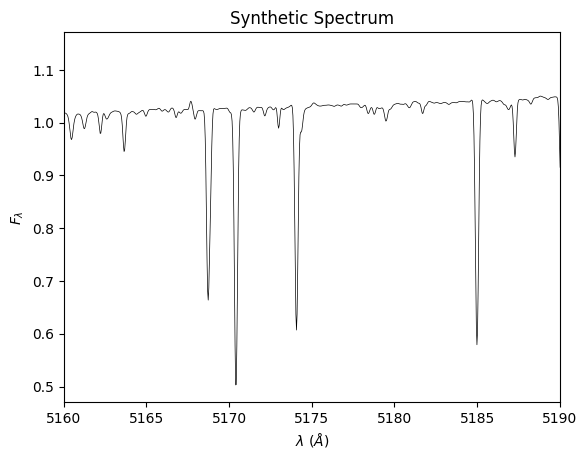

synthetic spectrum saved to /data/labs/douglste-laf-lab/sofairj/uberMSdemo/synth_spec_RV-3.csv


In [9]:
specNN='/data/labs/douglaslab/sofairj/demo_binary/models/specNN/modV0_spec_LinNet_R42K_WL510_535_wvt.h5'
NNtype='LinNet'

starpars = ([
            9700, # Teff
            4.306, # log(g)
            -0.12, # [Fe/H]
            0.11, # [a/Fe]
            -3.162806696, # vrad
            2.74, # vstar
            1.0, # vmic
            32007.42, # lsf (R)
            1.08, # pc0
            0.06, # pc1
            0.0, # pc2
            0.0, # pc3
    ])

# starpars = ([
#             7020, # Teff
#             4.274, # log(g)
#             -0.12, # [Fe/H]
#             0.11, # [a/Fe]
#             18.23115945, # vrad
#             2.74, # vstar
#             1.0, # vmic
#             32007.42, # lsf (R)
#             1.08, # pc0
#             0.06, # pc1
#             0.0, # pc2
#             0.0, # pc3
#     ])

gensynthspec(specNN=specNN, NNtype=NNtype, starpars=starpars, plot=True)

In [13]:
def gensynthphot(photNN='', NNtype='', starpars=([]), filtarr='', plot=False):
    if starpars:
        print(f"Photometric parameters:\n[Teff, log(g), [Fe/H], [a/Fe], log(R), dist, Av, Rv (3.1)]\n{starpars}")
    else:
        starpars = ([
                1, # Teff
                1, # log(g)
                1, # [Fe/H]
                1, # [a/Fe]
                1, # log(R)
                1, # Dist
                1, # Av
                3.1 # Rv (3.1)
        ])
        print(f"Photometric parameters:\n[Teff, log(g), [Fe/H], [a/Fe], log(R), dist, Av, Rv (3.1)]\n{starpars}")
    Teff = starpars[0]
    logg = starpars[1]

    # initialize model generation class
    GM = GenMod()
    GM._initphotnn(
        filterarray=filtarr,
        nnpath=photNN
    )

    # generate the model, output is an array of [filt_name,mag]
    photmod = GM.genphot(starpars)

    # grab just mags
    photmod = [photmod[xx] for xx in filtarr]

    from uberMS.utils import photsys

    # all filters the NN is trained on + some information on them
    WAVE_d = photsys.photsys()
    # print(f"\nWAVE_d: {WAVE_d}")

    # names of all of the filters the NN is trained on
    photbands_i = WAVE_d.keys()
    # print(f"\nphotbands_i: {photbands_i}")
    
    # names of the filters used in the "observation" (i.e., filters in filtarr)
    photbands = [x for x in photbands_i if x in filtarr]
    print(f"\nphotbands: {photbands}")

    # dict of {filter: wavelength}
    WAVE = {pb:WAVE_d[pb][0] for pb in photbands}
    print(f'\nwave:\n{WAVE}')

    # make some errors (taken from the known SB2 Gaia DR3 2076392838230907392)
    emags = [0.05000091916311386,
             0.05004763662644478,
             0.050012894094444295,
             0.07733692547677395,
             0.08683893326204858,
             0.10121264701645077,
             0.020829461749839007,
             0.02065512096136038,
             0.020870045165005097,
             0.020915354323712318
            ]
             
    # plot the synthetic photometry
    fig, ax = plt.subplots()

    if plot:
        # plot the model
        for wavelength, mag, err in zip(WAVE.values(), photmod, emags):
            ax.scatter(wavelength/1E+4, mag, c='k', s=5)
            # ax.errorbar(wavelength/1E+4, mag, yerr=err, ls='',marker=',',c='C3',zorder=1)
    
        ax.set_xlabel(r'$\lambda$ ($\mu$m)')
        ax.set_ylabel(r"Mag.")
        ax.set_title('Synthetic Photometry')
    
        plt.show()
        # plt.savefig(f"synth_spec_T{int(Teff)}.png")

    # output spectrum to csv
    with open(f'synth_phot_g{logg}.csv','w') as out:
        csv_out=csv.writer(out)
        csv_out.writerow(['band','mag','emag'])

        for row in zip(WAVE.keys(), photmod, emags):
            csv_out.writerow(row)
            print(row)
    print(f'synthetic photometry saved to {os.getcwd()}/synth_phot_g{logg}.csv')

Photometric parameters:
[Teff, log(g), [Fe/H], [a/Fe], log(R), dist, Av, Rv (3.1)]
[7020, 4.274, -0.12, 0.11, 1.504, 138.3106734, 1.0, 3.1]

photbands: ['GaiaDR3_G', 'GaiaDR3_BP', 'GaiaDR3_RP', '2MASS_J', '2MASS_H', '2MASS_Ks', 'PS_g', 'PS_r', 'PS_i', 'PS_z']

wave:
{'GaiaDR3_G': 6217.59, 'GaiaDR3_BP': 5109.71, 'GaiaDR3_RP': 7769.02, '2MASS_J': 12350.0, '2MASS_H': 16620.0, '2MASS_Ks': 21590.0, 'PS_g': 4775.6, 'PS_r': 6129.5, 'PS_i': 7484.6, 'PS_z': 8657.8}


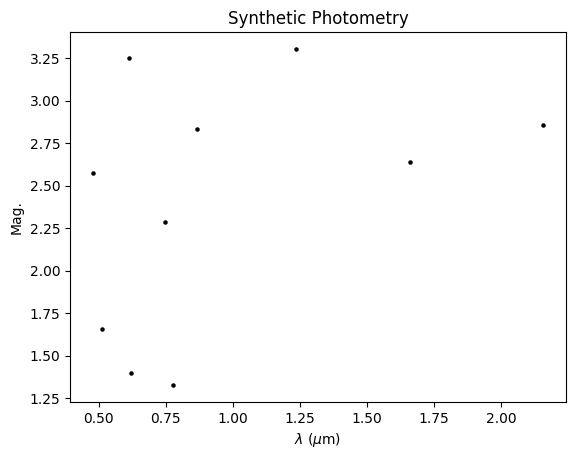

('GaiaDR3_G', 1.399261987667753, 0.05000091916311386)
('GaiaDR3_BP', 1.6586724166279474, 0.05004763662644478)
('GaiaDR3_RP', 1.3277482873206559, 0.050012894094444295)
('2MASS_J', 3.3044609464458268, 0.07733692547677395)
('2MASS_H', 2.6418549323417855, 0.08683893326204858)
('2MASS_Ks', 2.8561933016305723, 0.10121264701645077)
('PS_g', 2.5742217986746465, 0.020829461749839007)
('PS_r', 3.24996712511108, 0.02065512096136038)
('PS_i', 2.2846383920750615, 0.020870045165005097)
('PS_z', 2.8335038724530612, 0.020915354323712318)
synthetic photometry saved to /data/labs/douglste-laf-lab/sofairj/uberMSdemo/synth_phot_g4.274.csv


In [16]:
photNN='/data/labs/douglaslab/sofairj/demo_binary/models/photNN/'
NNtype='LinNet'
# starpars = ([
#             9700, # Teff
#             4.306, # log(g)
#             -0.12, # [Fe/H]
#             0.11, # [a/Fe]
#             1.723, # log(R)
#             138.3106734, # dist (pc)
#             1.0, # Av
#             3.1, # lsf (R)
#     ])

starpars = ([
            7020, # Teff
            4.274, # log(g)
            -0.12, # [Fe/H]
            0.11, # [a/Fe]
            1.504, # log(R)
            138.3106734, # dist (pc)
            1.0, # Av
            3.1, # lsf (R)
    ])

filtarr = ['2MASS_H', '2MASS_J', '2MASS_Ks', 'PS_g', 'PS_i', 'PS_r', 'PS_z', 'GaiaDR3_BP', 'GaiaDR3_RP', 'GaiaDR3_G']

gensynthphot(photNN=photNN, NNtype=NNtype, starpars=starpars, filtarr=filtarr, plot=True)

Photometric parameters:
[Teff, log(g), [Fe/H], [a/Fe], log(R), dist, Av, Rv (3.1)]
[6461.25, 4.05, -1.17, 0.31, 0.15, 1483.0785999225207, 0.26, 31990.09]

photbands: ['GaiaDR3_G', 'GaiaDR3_BP', 'GaiaDR3_RP', '2MASS_J', '2MASS_H', '2MASS_Ks', 'PS_g', 'PS_r', 'PS_i', 'PS_z']

wave:
{'GaiaDR3_G': 6217.59, 'GaiaDR3_BP': 5109.71, 'GaiaDR3_RP': 7769.02, '2MASS_J': 12350.0, '2MASS_H': 16620.0, '2MASS_Ks': 21590.0, 'PS_g': 4775.6, 'PS_r': 6129.5, 'PS_i': 7484.6, 'PS_z': 8657.8}


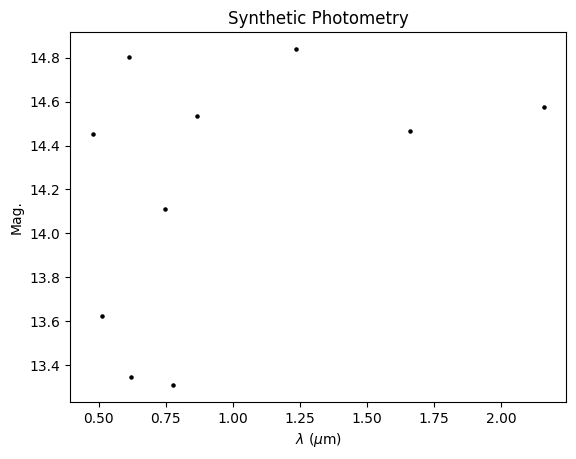

synthetic photometry saved to /data/labs/douglste-laf-lab/sofairj/uberMSdemo/synth_phot_g4.05.csv


In [22]:
photNN='/data/labs/douglaslab/sofairj/demo_binary/models/photNN/'
NNtype='LinNet'
starpars = ([
            6461.25, # Teff
            4.05, # log(g)
            -1.17, # [Fe/H]
            0.31, # [a/Fe]
            0.15, # log(R)
            1000/0.67427309655216, # dist (pc)
            0.26, # Av
            31990.09, # lsf (R)
    ])

filtarr = ['2MASS_H', '2MASS_J', '2MASS_Ks', 'PS_g', 'PS_i', 'PS_r', 'PS_z', 'GaiaDR3_BP', 'GaiaDR3_RP', 'GaiaDR3_G']

gensynthphot(photNN=photNN, NNtype=NNtype, starpars=starpars, filtarr=filtarr, plot=True)

In [65]:
phot = Table.read('/data/labs/douglaslab/sofairj/demo_smes/data/phot.dat',format='ascii')
phot

band,mag,emag
str10,float64,float64
2MASS_H,12.717,0.022
2MASS_J,12.986,0.021
2MASS_Ks,12.636,0.021
GaiaDR3_BP,14.296,0.001
GaiaDR3_G,13.996,0.0002
GaiaDR3_RP,13.531,0.001
PS_g,14.316,0.003
WISE_W1,12.629,0.002
WISE_W2,12.667,0.002


In [112]:
hecto_dir = os.path.expanduser("/data/labs/douglaslab/sofairj/data/hectochelle_rereduction")
hecto_filename = os.path.join(hecto_dir, "data_ngc6819_2010.0921_ngc6819_sep2010_1.7137.h5")
f = h5py.File(hecto_filename, 'r')


# 2080061393129929088 is the first star listed in the spectrum used here
# 2128158910811247488 is an SB2 whose components are separated in most spectra
# (data_ngc6811_2019.0516_hectochelle_NGC6811_2019b_1.8149.h5)
# 2076392838230907392 is another relevant SB2 in NGC 6819
target = str(2076392838230907392)
spec = Table([f[target]['wave'], f[target]['flux'],
              f[target]['eflux']],
              names=('wave', 'flux', 'eflux'))

mu, sigma = np.mean(spec['eflux']), np.std(spec['eflux']) # mean and standard deviation
# np.random.seed(0)
print(mu, sigma)
s = np.random.normal(mu, sigma, 1000)
np.where(s < 0)

0.055402016862253524 0.004453214396949145


(array([], dtype=int64),)

In [65]:
Table.read('synth_phot_g4.16.csv')

band,mag,emag
str10,float64,float64
GaiaDR3_G,-16.637890924089547,0.0002
GaiaDR3_BP,-16.175446561166957,0.001
GaiaDR3_RP,-16.7349998115222,0.001
2MASS_J,-13.789127976469755,0.021
2MASS_H,-14.885809065278274,0.022
2MASS_Ks,-14.520227531090923,0.021
PS_g,-15.064029344687393,0.003
PS_r,-13.96255753187274,0.002
PS_i,-15.256110508864127,0.002


In [ ]:
Table.read('synth_spec_RV25.csv')

In [ ]:
Table.read('/data/labs/douglaslab/sofairj/demo_smes/data/spec.fits')

In [51]:
# test = Table.read('/data/labs/douglaslab/sofairj/uberMSdemo/obs_wave.csv', dtype='float64')
# print(test[0])
# np.array(test)
# print(test.as_array())

In [5]:
data = Table.read('obs_wave.csv')['wave']
np.array(data)

array([5160.03358324, 5160.06969536, 5160.10580743, ..., 5289.92984211,
       5289.96213975, 5289.99443551])

In [6]:
np.array(Table.read('obs_wave.csv')['wave'])

array([5160.03358324, 5160.06969536, 5160.10580743, ..., 5289.92984211,
       5289.96213975, 5289.99443551])